# Forecasting for Adminstered Vaccinations

## Importing Libraries

In [187]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

%matplotlib inline

from sklearn.metrics import mean_absolute_error, mean_squared_error

import warnings
warnings.filterwarnings("ignore")
warnings.filterwarnings("ignore", message="your warning message")

## Fetch all Regions

In [188]:
def fetch_data():
    url = "https://api.covid19tracker.ca/regions"
    response = requests.get(url)
    return response.json()

## Get Region ID

In [189]:
def get_region_id(region_name):
    data = fetch_data()
    for region in data['data']:
        if region_name.lower() in region['engname'].lower():
            return region['hr_uid']
    return "Region ID not found."

region_name = "Thunder Bay District Health Unit"
region_id = get_region_id(region_name)
print(f"Region ID for {region_name}: {region_id}")

Region ID for Thunder Bay District Health Unit: 3562


## Vaccination Data

In [190]:
def vaccinationData(region_id):
    url = f"https://api.covid19tracker.ca/reports/regions/{region_id}"
    response = requests.get(url)
    return response.json()
    
data = vaccinationData(region_id)

## Converting to DataFrame


In [191]:
data_vacs = pd.DataFrame(data['data'])

data_vacs['date'] = pd.to_datetime(data_vacs['date'])
data_vacs = data_vacs[['change_vaccinations', 'date']]

data_vacs.shape

data_vacs.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1477 entries, 0 to 1476
Data columns (total 2 columns):
 #   Column               Non-Null Count  Dtype         
---  ------               --------------  -----         
 0   change_vaccinations  935 non-null    float64       
 1   date                 1477 non-null   datetime64[ns]
dtypes: datetime64[ns](1), float64(1)
memory usage: 23.2 KB


## Cleaning Data


In [192]:
last15 = data_vacs.iloc[-15:,:]

# As you can see some of the values in change_vaccinated = 0 which means there is no data for that day and it is filled in.
print(last15)

      change_vaccinations       date
1462                  4.0 2024-03-13
1463                -60.0 2024-03-14
1464                  1.0 2024-03-15
1465                  0.0 2024-03-16
1466                  0.0 2024-03-17
1467                  0.0 2024-03-18
1468                  1.0 2024-03-19
1469                  0.0 2024-03-20
1470                -50.0 2024-03-21
1471                  0.0 2024-03-22
1472                  2.0 2024-03-23
1473                  0.0 2024-03-24
1474                  0.0 2024-03-25
1475                  0.0 2024-03-26
1476                  0.0 2024-03-27


In [193]:
data_vacs['change_vaccinations'] = data_vacs['change_vaccinations'].fillna(0)
data_vacs['change_vaccinations'] = data_vacs['change_vaccinations'].apply(lambda x: 0 if x < 0 else x)
data_vacs['change_vaccinations'] = data_vacs['change_vaccinations'].apply(lambda x: 5000 if x > 30000 else x)

data_vacs['total_vaccinated'] = data_vacs['change_vaccinations'].cumsum()

data_vacs_days = data_vacs

last15 = data_vacs.iloc[-15:,:]

print(last15)

      change_vaccinations       date  total_vaccinated
1462                  4.0 2024-03-13          317949.0
1463                  0.0 2024-03-14          317949.0
1464                  1.0 2024-03-15          317950.0
1465                  0.0 2024-03-16          317950.0
1466                  0.0 2024-03-17          317950.0
1467                  0.0 2024-03-18          317950.0
1468                  1.0 2024-03-19          317951.0
1469                  0.0 2024-03-20          317951.0
1470                  0.0 2024-03-21          317951.0
1471                  0.0 2024-03-22          317951.0
1472                  2.0 2024-03-23          317953.0
1473                  0.0 2024-03-24          317953.0
1474                  0.0 2024-03-25          317953.0
1475                  0.0 2024-03-26          317953.0
1476                  0.0 2024-03-27          317953.0


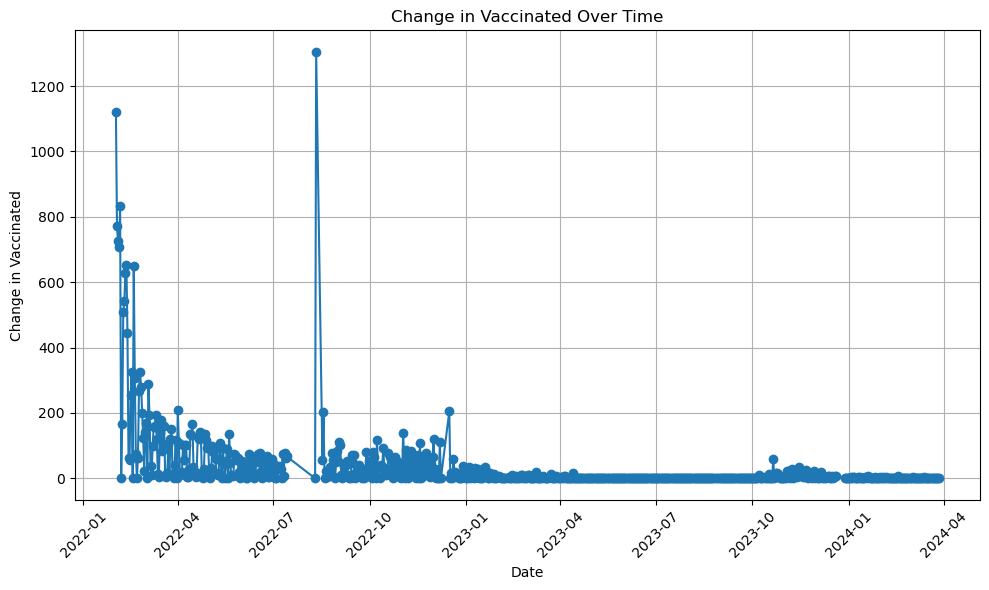

In [194]:
# # Plotting the data
plt.figure(figsize=(10, 6))

# Filter the DataFrame to include dates from 2022-01-01 onwards
data_vacs_days = data_vacs_days[data_vacs_days['date'] >= '2022-02-01']

plt.plot(data_vacs_days['date'], data_vacs_days['change_vaccinations'], marker='o', linestyle='-')
plt.title('Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

In [195]:
# Count the number of negative values in the 'change_vaccinated' column
negative_count = (data_vacs_days['change_vaccinations'] < 0).sum()

print("Number of negative values in the 'change_vaccinated' column:", negative_count)

Number of negative values in the 'change_vaccinated' column: 0


# Holt's Method (Double Exponential Smoothing) - Days DataFrame 

In [196]:
# importing for Exponential Smoothing 

from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [197]:
time_series_data = data_vacs_days.set_index('date')['total_vaccinated']

In [198]:
# Create Holt's exponential smoothing model 

model = ExponentialSmoothing(time_series_data, trend='add', damped=True)

In [199]:
# Fit Holt's exponential smoothing model 

fit_model = model.fit()

In [200]:
# Forecasting values for the next year (365 days)

forecast_steps = 365
forecast = fit_model.forecast(steps=forecast_steps)
forecast = np.ceil(forecast)
forecast.head()

729    317954.0
730    317954.0
731    317955.0
732    317955.0
733    317955.0
dtype: float64

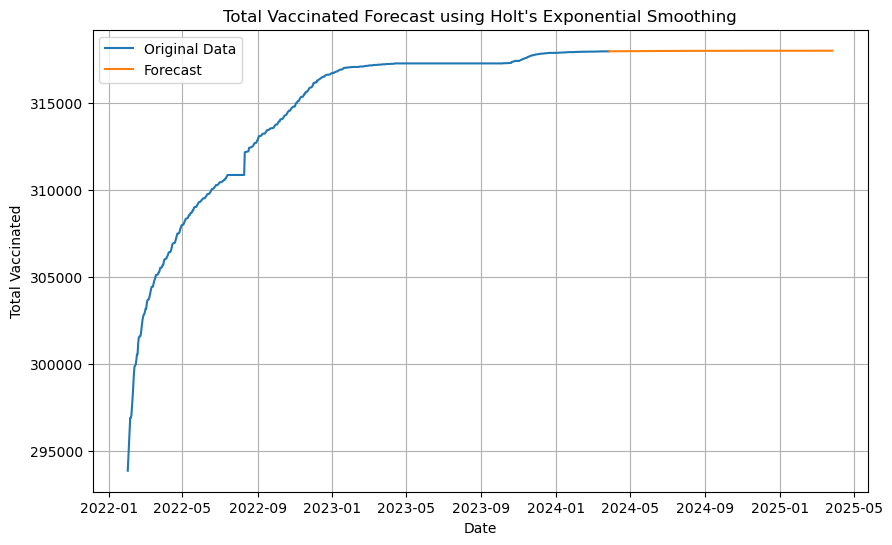

In [201]:
# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, label='Forecast')
plt.title('Total Vaccinated Forecast using Holt\'s Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.legend()
plt.grid(True)
plt.show()

In [202]:
# Create a dataframe from the forecast 

# Set the date as index
forecast_start_date = data_vacs_days['date'].iloc[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='D')

# Create a dataframe from the forecast 
forecast_df = pd.DataFrame({'date': forecast_dates, 'Forecasted Total Vaccinated': forecast})

forecast_df.head()


,date,Forecasted Total Vaccinated
729,2024-03-28,317954.0
730,2024-03-29,317954.0
731,2024-03-30,317955.0
732,2024-03-31,317955.0
733,2024-04-01,317955.0


In [203]:
# Get the last total vaccinated value from the original dataset
last_total_vaccinated = data_vacs_days['total_vaccinated'].iloc[-1]

# Add the Forecasted Change Vaccinated 
forecast_df['Forecasted Change Vaccinated'] = forecast_df['Forecasted Total Vaccinated'].diff()

# For the first row, use the last total vaccinated value
forecast_df['Forecasted Change Vaccinated'].iloc[0] = forecast_df['Forecasted Total Vaccinated'].iloc[0] - last_total_vaccinated

forecast_df.head()

,date,Forecasted Total Vaccinated,Forecasted Change Vaccinated
729,2024-03-28,317954.0,1.0
730,2024-03-29,317954.0,0.0
731,2024-03-30,317955.0,1.0
732,2024-03-31,317955.0,0.0
733,2024-04-01,317955.0,0.0


In [204]:
forecast_df.tail()

,date,Forecasted Total Vaccinated,Forecasted Change Vaccinated
1089,2025-03-23,317988.0,0.0
1090,2025-03-24,317988.0,0.0
1091,2025-03-25,317988.0,0.0
1092,2025-03-26,317988.0,0.0
1093,2025-03-27,317988.0,0.0


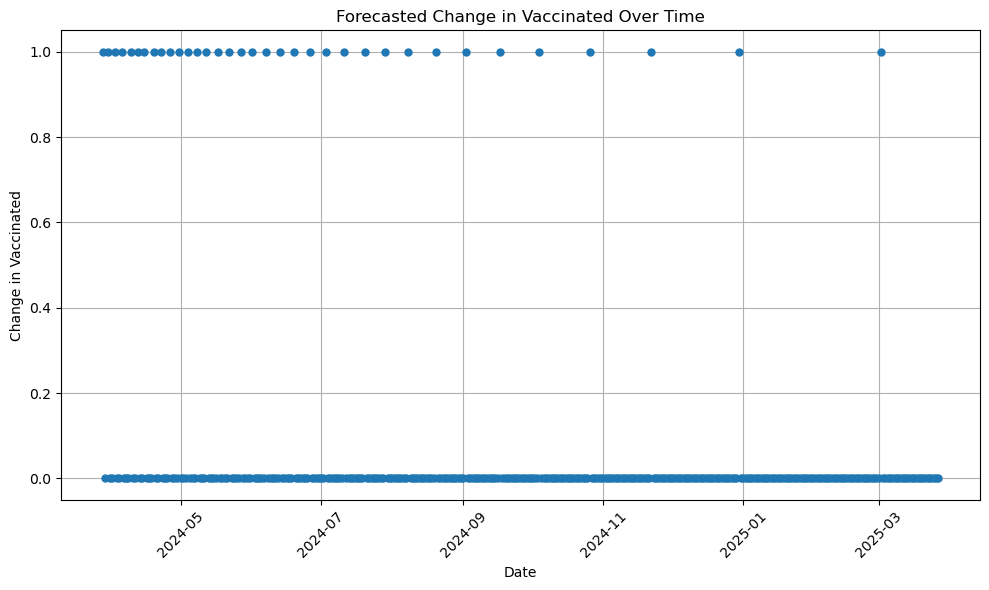

In [205]:
# Plotting the forecasted change vaccinated
plt.figure(figsize=(10, 6))
plt.plot(forecast_df['date'], forecast_df['Forecasted Change Vaccinated'], marker='o', linestyle=' ', markersize=5)
plt.title('Forecasted Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Error analysis for Holt's method (exponential smoothing) 

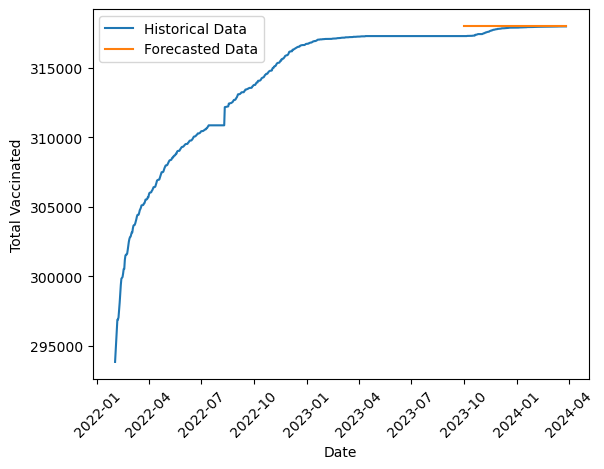

In [206]:
# Split data into training (until 2024-03-08) and testing (from 2023-03-09) sets
train_data = data_vacs_days[data_vacs_days['date'] <= '2023-10-01']
test_data = data_vacs_days[data_vacs_days['date'] >= '2023-10-02']

# Train the model
model = ExponentialSmoothing(time_series_data, trend='add', damped=True)
fit_model = model.fit()

# Forecast total vaccinated values for the entire desired time period
forecast_steps = len(test_data)
forecast = fit_model.predict(start=test_data.index.min(), end=test_data.index.max())

plt.plot(data_vacs_days['date'], data_vacs_days['total_vaccinated'], label='Historical Data')
plt.plot(test_data['date'], forecast, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [207]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['total_vaccinated'], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['total_vaccinated'], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 236.82672450228316
Mean Squared Error (MSE): 110766.56190532344
Root Mean Squared Error (RMSE): 332.8161082419591


## Creating 10-week intervals

In [208]:
# Convert index to DatetimeIndex
forecast_df.index = pd.to_datetime(forecast_df.index)

# Assuming you want to group by 2-week intervals based on the date
# We find the min date and use it to calculate the difference in days for grouping
min_date = forecast_df['date'].min()
forecast_df['interval'] = (forecast_df['date'] - min_date).dt.days // 70

# Now, group by this 'interval' column and aggregate the data
grouped_data_vacs = forecast_df.groupby('interval').agg({
    'Forecasted Change Vaccinated': 'sum',
    'Forecasted Total Vaccinated': 'last',
    'date': ['min', 'max']
}).reset_index()

# Cleaning up the DataFrame columns
grouped_data_vacs.columns = ['Interval', 'Change Vaccinated', 'Total Vaccinated', 'Start Date', 'End Date']

print(grouped_data_vacs)

grouped_data_vacs.to_csv('Thunder_Bay_District_Change_Vaccinated.csv', index=False)

   Interval  Change Vaccinated  Total Vaccinated Start Date   End Date
0         0               18.0          317971.0 2024-03-28 2024-06-05
1         1                9.0          317980.0 2024-06-06 2024-08-14
2         2                4.0          317984.0 2024-08-15 2024-10-23
3         3                3.0          317987.0 2024-10-24 2025-01-01
4         4                1.0          317988.0 2025-01-02 2025-03-12
5         5                0.0          317988.0 2025-03-13 2025-03-27


## Plot to see Sum Change Vaccinated VS Interval

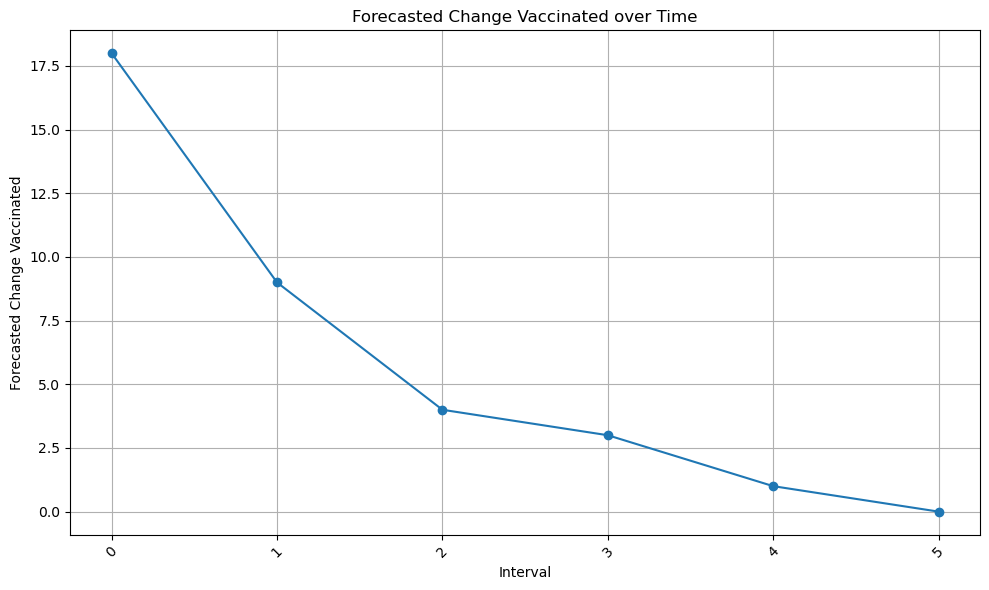

In [209]:
# This plot sees the change vaccinated over time in the 10 week intervals

plt.figure(figsize=(10, 6))
plt.plot(grouped_data_vacs.index, grouped_data_vacs['Change Vaccinated'], marker='o', linestyle='-')
plt.xlabel('Interval')
plt.ylabel('Forecasted Change Vaccinated')
plt.title('Forecasted Change Vaccinated over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

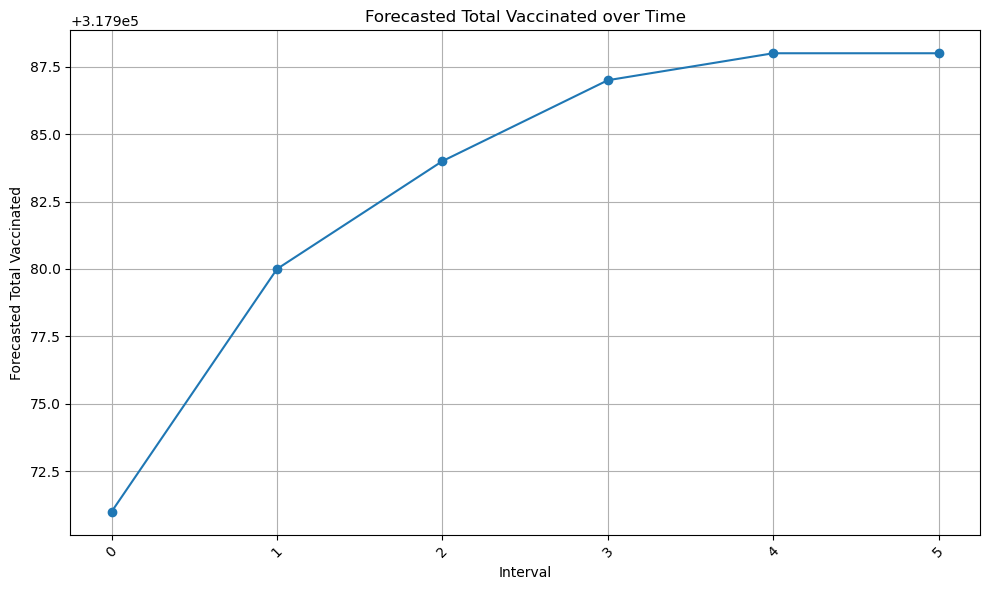

In [210]:
# This plot sees the total vaccinations over time in the 10 week intervals

plt.figure(figsize=(10, 6))
plt.plot(grouped_data_vacs.index, grouped_data_vacs['Total Vaccinated'], marker='o', linestyle='-')
plt.xlabel('Interval')
plt.ylabel('Forecasted Total Vaccinated')
plt.title('Forecasted Total Vaccinated over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

# Simple Exponential Smoothing

In [211]:
# imports for simple exponential smoothing 

from statsmodels.tsa.api import SimpleExpSmoothing

In [212]:
time_series_data = data_vacs_days.set_index('date')['total_vaccinated']

print(time_series_data)
model = SimpleExpSmoothing(time_series_data)
ses_model = model.fit(smoothing_level = 0.2)

date
2022-02-01    293859.0
2022-02-02    294630.0
2022-02-03    295355.0
2022-02-04    296062.0
2022-02-05    296895.0
                ...   
2024-03-23    317953.0
2024-03-24    317953.0
2024-03-25    317953.0
2024-03-26    317953.0
2024-03-27    317953.0
Name: total_vaccinated, Length: 729, dtype: float64


In [213]:
forecast_steps = 365
forecast = ses_model.forecast(steps=forecast_steps)
forecast = np.ceil(forecast)
forecast.head()

729    317952.0
730    317952.0
731    317952.0
732    317952.0
733    317952.0
dtype: float64

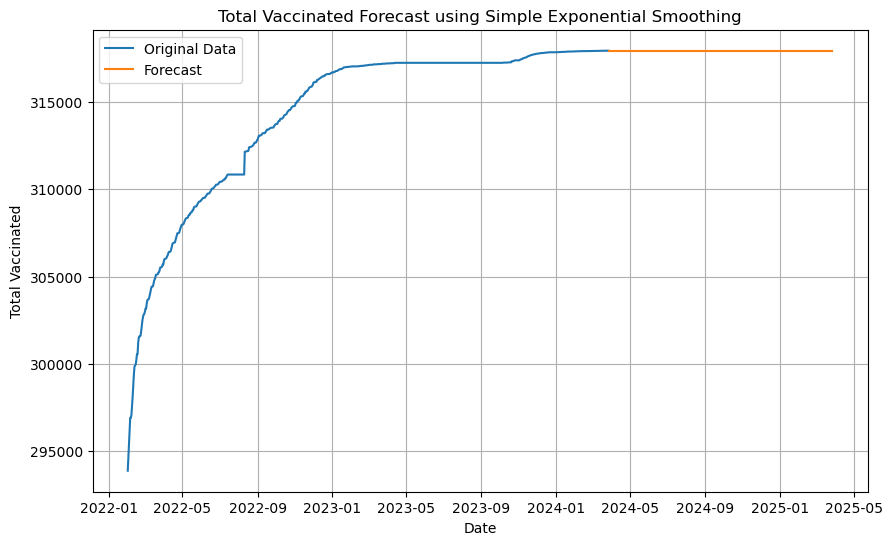

In [214]:
plt.figure(figsize=(10, 6))
plt.plot(time_series_data.index, time_series_data, label='Original Data')
plt.plot(pd.date_range(start=time_series_data.index[-1], periods=forecast_steps + 1, freq='D')[1:], forecast, label='Forecast')
plt.title('Total Vaccinated Forecast using Simple Exponential Smoothing')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.legend()
plt.grid(True)
plt.show()

In [215]:
# Create a dataframe from the forecast 

# Set the date as index
forecast_start_date = data_vacs_days['date'].iloc[-1] + pd.Timedelta(days=1)
forecast_dates = pd.date_range(start=forecast_start_date, periods=forecast_steps, freq='D')

# Create a dataframe from the forecast 
forecast_df = pd.DataFrame({'date': forecast_dates, 'Forecasted Total Vaccinated': forecast})

forecast_df.head()

# Add the Forecasted Change Vaccinated 

forecast_df['Forecasted Change Vaccinated'] = forecast_df['Forecasted Total Vaccinated'].diff()

# Get the last total vaccinated value from the original dataset
last_total_vaccinated = data_vacs_days['total_vaccinated'].iloc[-1]

# For the first row, use the last total vaccinated value
forecast_df['Forecasted Change Vaccinated'].iloc[0] = 0


forecast_df.head()

,date,Forecasted Total Vaccinated,Forecasted Change Vaccinated
729,2024-03-28,317952.0,0.0
730,2024-03-29,317952.0,0.0
731,2024-03-30,317952.0,0.0
732,2024-03-31,317952.0,0.0
733,2024-04-01,317952.0,0.0


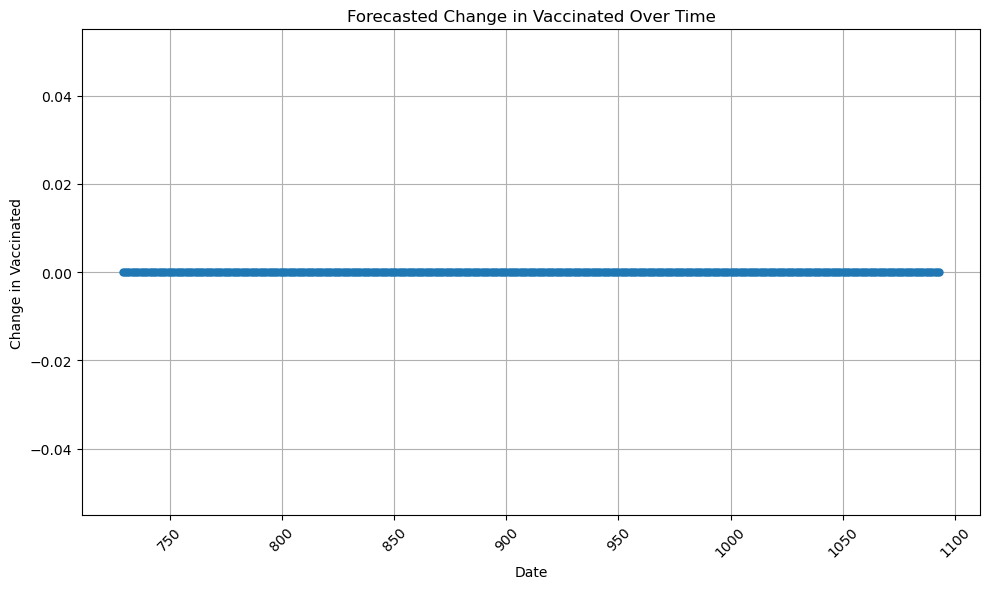

In [216]:
# Plotting the forecasted change vaccinated
plt.figure(figsize=(10, 6))
plt.plot(forecast_df.index, forecast_df['Forecasted Change Vaccinated'], marker='o', linestyle='', markersize=5)
plt.title('Forecasted Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

## Error analysis for Holt's method (exponential smoothing) 

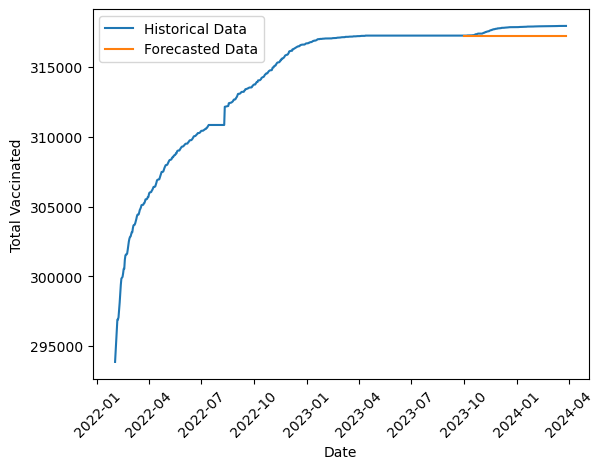

In [217]:
# Convert 'date' column to datetime
data_vacs_days['date'] = pd.to_datetime(data_vacs_days['date'])

# Split data into training (until 2024-03-08) and testing (from 2024-03-09) sets
train_data = data_vacs_days[data_vacs_days['date'] <= '2023-10-01']
test_data = data_vacs_days[data_vacs_days['date'] >= '2023-10-02']

# Extract time series data for training
time_series_data = train_data.set_index('date')['total_vaccinated']

# Train the model
model = SimpleExpSmoothing(time_series_data)
ses_model = model.fit()

# Forecast total vaccinated values for the entire desired time period
forecast_steps = len(test_data)
forecast = ses_model.predict(start=test_data.index.min(), end=test_data.index.max())

plt.plot(data_vacs_days['date'], data_vacs_days['total_vaccinated'], label='Historical Data')
plt.plot(test_data['date'], forecast, label='Forecasted Data')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.xticks(rotation=45)
plt.legend()
plt.show()

In [218]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(test_data['total_vaccinated'], forecast)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(test_data['total_vaccinated'], forecast)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 492.28402366863907
Mean Squared Error (MSE): 297034.0118343195
Root Mean Squared Error (RMSE): 545.0082676751973


# Linear Regression Model

In [219]:
# Convert dates to timestamps
X = data_vacs_days['date'].astype('int64').values.reshape(-1, 1)
y = data_vacs_days['change_vaccinations'].values

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = LinearRegression()

model.fit(X_train, y_train)
y_pred = model.predict(X_test)

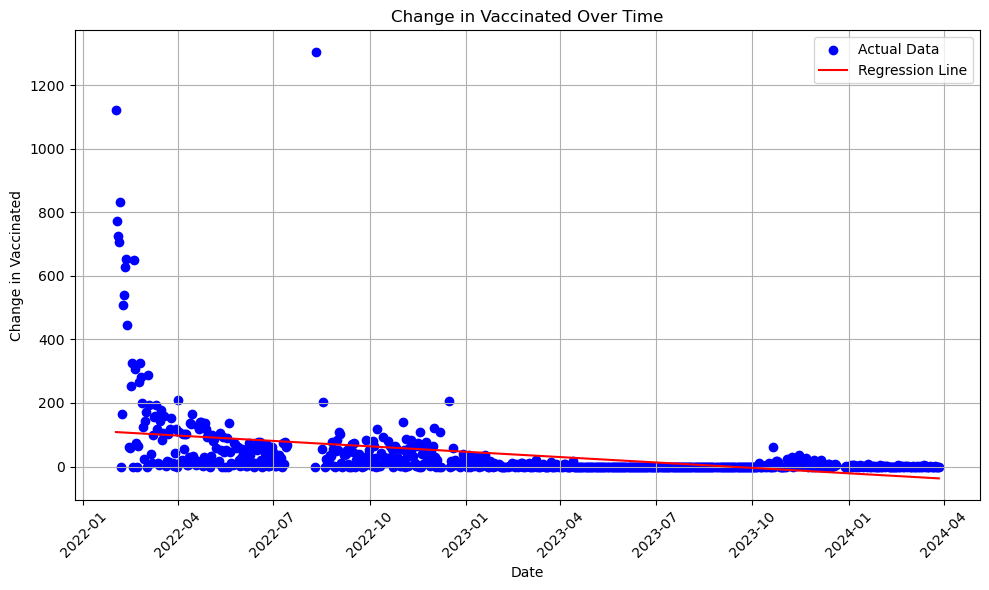

In [220]:
# Plot the original data and regression line
plt.figure(figsize=(10, 6))
plt.scatter(data_vacs_days['date'], data_vacs_days['change_vaccinations'], color='blue', label='Actual Data')
plt.plot(data_vacs_days['date'], model.predict(X), color='red', label='Regression Line')
plt.title('Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Change in Vaccinated')
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

In [221]:
# Calculate Mean Absolute Error (MAE)
mae = mean_absolute_error(y_test, y_pred)

# Calculate Mean Squared Error (MSE)
mse = mean_squared_error(y_test, y_pred)

# Calculate Root Mean Squared Error (RMSE)
rmse = mse ** 0.5

print("Mean Absolute Error (MAE):", mae)
print("Mean Squared Error (MSE):", mse)
print("Root Mean Squared Error (RMSE):", rmse)

Mean Absolute Error (MAE): 50.002540455847374
Mean Squared Error (MSE): 17119.003205964196
Root Mean Squared Error (RMSE): 130.83960870456696


In [222]:
# Convert dates to timestamps

# Make predictions for the next 2 years (1008 days)
future_dates = pd.date_range(start=data_vacs_days['date'].iloc[-1], periods=365)
future_dates_timestamps = future_dates.astype('int64').values.reshape(-1, 1)
forecast_total_vaccinated = model.predict(future_dates_timestamps)

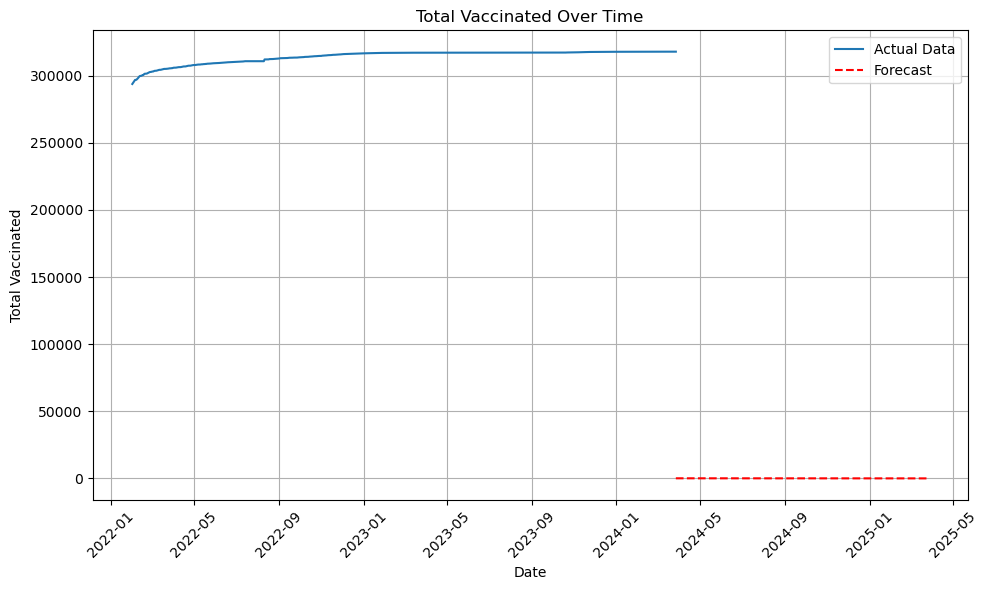

In [223]:
# Plot the original data and forecasted values
plt.figure(figsize=(10, 6))
plt.plot(data_vacs_days['date'], data_vacs_days['total_vaccinated'], label='Actual Data')
plt.plot(future_dates, forecast_total_vaccinated, label='Forecast', linestyle='--', color='red')
plt.title('Total Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Total Vaccinated')
plt.legend()
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [224]:
# Create a DataFrame for the forecasted total vaccinated values
forecasted_total_df = pd.DataFrame({'date': future_dates, 'forecasted_total_vaccinated': forecast_total_vaccinated})

print(forecasted_total_df)

          date  forecasted_total_vaccinated
0   2024-03-27                   -37.315358
1   2024-03-28                   -37.501001
2   2024-03-29                   -37.686644
3   2024-03-30                   -37.872287
4   2024-03-31                   -38.057930
..         ...                          ...
360 2025-03-22                  -104.146860
361 2025-03-23                  -104.332503
362 2025-03-24                  -104.518146
363 2025-03-25                  -104.703789
364 2025-03-26                  -104.889432

[365 rows x 2 columns]


## Forecasted Change

In [225]:
forecasted_change_vaccinated = np.diff(np.concatenate([[data_vacs_days['total_vaccinated'].iloc[-1]], forecast_total_vaccinated]))

future_dates = future_dates[:-1]
forecasted_change_vaccinated = forecasted_change_vaccinated[:-1]

# Create a DataFrame for the forecasted change in vaccinated
forecasted_change_df = pd.DataFrame({'date': future_dates, 'forecasted_change_vaccinated': forecasted_change_vaccinated})

# Get the last total vaccinated value from the original dataset
last_total_vaccinated = data_vacs_days['total_vaccinated'].iloc[-1]

# For the first row, use the last total vaccinated value
first_forecasted_total_vaccinated = forecast_total_vaccinated[0]
forecasted_change_df['forecasted_change_vaccinated'].iloc[0] = first_forecasted_total_vaccinated - last_total_vaccinated

print(forecasted_change_df.head())


        date  forecasted_change_vaccinated
0 2024-03-27                -317990.315358
1 2024-03-28                     -0.185643
2 2024-03-29                     -0.185643
3 2024-03-30                     -0.185643
4 2024-03-31                     -0.185643


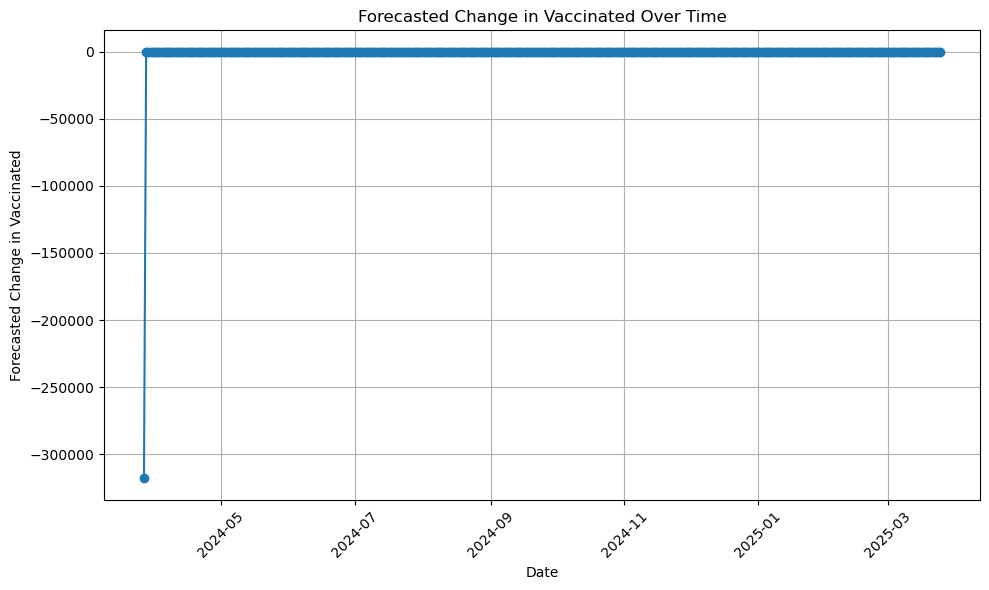

In [226]:
# Plot the forecasted change in vaccinated
plt.figure(figsize=(10, 6))
plt.plot(forecasted_change_df['date'], forecasted_change_df['forecasted_change_vaccinated'], marker='o', linestyle='-')
plt.title('Forecasted Change in Vaccinated Over Time')
plt.xlabel('Date')
plt.ylabel('Forecasted Change in Vaccinated')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()